In [1]:
#Importing packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Importing data
train_data = pd.read_csv('Training Data.csv')
train_labels = pd.read_csv('Training Labels.csv')
test_data = pd.read_csv('Test Set.csv')

#Combine train and test data
train_data['train'] = 1
test_data['train'] = 0
dataset = pd.concat([train_data,test_data])

In [3]:
# Looking at high level summary of data

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 41 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null object
funder                   69746 non-null object
gps_height               74250 non-null int64
installer                69718 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null object
num_private              74250 non-null int64
basin                    74250 non-null object
subvillage               73780 non-null object
region                   74250 non-null object
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null object
ward                     74250 non-null object
population               74250 non-null int64
public_meeting           70095 non-null object
r

In [4]:
#Looking at summary statistics of data

dataset.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,train
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650,0.800000
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375,0.400003
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000,1.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,1.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,1.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,1.000000


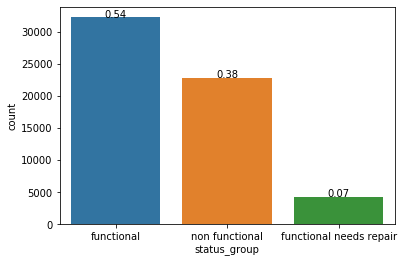

In [5]:
#Plotting distribution of functionality of water pumps in train set

ax = sns.countplot(x="status_group", data=train_labels)

total = float(len(train_labels))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show()

In [6]:
#Dropping irrelevant columns
dataset = dataset.drop(columns = ['date_recorded','gps_height','longitude','latitude','wpt_name','num_private','subvillage','lga','ward','recorded_by','extraction_type_group','extraction_type','scheme_name','management','waterpoint_type_group','source','source_class','quantity_group','quality_group','payment_type'])

In [7]:
#Imputation

def imputer(value):
    
    #Finding the counts where region has True and False for that feature
    
    region_true_values = dataset.loc[dataset[value] == True]
    region_true_values = region_true_values.region.value_counts().reset_index()

    region_false_values = dataset.loc[dataset[value] == False]
    region_false_values = region_false_values.region.value_counts().reset_index()
    

    #Appending Values of True or False to combined dataset of counts
    
    combined_counts = pd.merge(region_true_values, region_false_values, on = 'index')
    combined_counts['choice'] = 'True'

    combined_counter = []

    for i in range(len(combined_counts)):
        if combined_counts['region_x'][i] > combined_counts['region_y'][i]:
            combined_counter.append('True')
        else:
            combined_counter.append('False')

    combined_counts['choice'] = combined_counter
    
    
    #Finding the regions that would be false
    new_falses = combined_counts.loc[combined_counts['choice'] == 'False']
 
    #Replacing NaN values with either True or False, based on the region name
    
    null_values = dataset.loc[dataset[value].isna()]

    for i in range(len(null_values)):
        if null_values['region'].iloc[i] == list(new_falses['index']):
            null_values[value].iloc[i] = False 
        else:
            null_values[value].iloc[i] = True 
     
    #Replacing back in dataset
    dataset.loc[dataset[value].isna()] = null_values
        

imputer('permit')
imputer('public_meeting')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Converting boolean columns to integers

dataset.permit = dataset.permit.astype(bool).astype(int)
dataset.public_meeting = dataset.public_meeting.astype(bool).astype(int)

In [9]:
# Get top n values in the extremely large columns - 30 for funder and installer; 9 for scheme_management
#Scheme management is 9 so that each class has 1000 values and above, and would solve the missing values problem.

def get_n(x,y):
    
    list_a = set(x.value_counts().index[:y].values) #Gets the top n values from the series
    x[~x.isin(list_a)] = 'Other' # Replaces everything else with Other
    #Uses a boolean mask for vectorisation as it is way faster than a for loop; tilda - inverts the boolean mask
    return x

dataset.funder = get_n(dataset.funder,30)
dataset.installer = get_n(dataset.installer,30)
dataset.scheme_management = get_n(dataset.scheme_management,9)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
#One Hot Encoding for other features

cat_columns = ['basin','scheme_management','quantity',
               'extraction_type_class', 'management_group','payment', 
               'water_quality', 'source_type','waterpoint_type',
               'region','installer', 'funder']

dataset = pd.get_dummies(dataset,columns = cat_columns)

In [11]:
#Status Group Ordinality Formatting

label_dict_status_group = {'functional':0,
                           'non functional': 1,
                           'functional needs repair': 2}

train_labels.status_group = train_labels.status_group.replace(label_dict_status_group)

In [12]:
#Splitting Dataset to train and test

new_train = dataset[dataset['train']==1]
new_train = new_train.drop(['train'],axis=1)
new_test = dataset[dataset['train']==0]
new_test = new_test.drop(['train'],axis=1)

#Merging Labels to train set

new_train = pd.merge(new_train, train_labels, on = 'id')
new_train = new_train.drop(['id'],axis=1)
new_test = new_test.drop(['id'],axis=1)

In [13]:
#Copying to a csv file

new_train.to_csv('new_train.csv', sep=',', encoding='utf-8', index=False)
new_test.to_csv('new_test.csv', sep=',', encoding='utf-8', index=False)